<a href="https://colab.research.google.com/github/ashoka-swiftclaims/Donut/blob/main/Fine_tuning_Donut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
%%bash
# clone repository
# git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
git clone https://github.com/ashoka-swiftclaims/Donut.git
# copy data
# cp -r ICDAR-2019-SROIE/data ./
cp -r Donut/data ./
# clean up
# rm -rf ICDAR-2019-SROIE
rm -rf Donut
rm -rf data/box

Cloning into 'Donut'...


In [4]:
!ls -a data/img/
!ls -a data/key/

.  ..  000.jpg	001.jpg  002.jpg  003.jpg  004.jpg  005.jpg  metadata.jsonl
.  ..  000.json  001.json  002.json  003.json  004.json  005.json


In [5]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# print(metadata_path)
# print(image_path)
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    print(data)
    # create "text" column with json string
    text = json.dumps(data)
    print(text)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      print(metadata_list)
    else:
      print(f"Image {file_name.stem}.jpg does not exist")
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)

{'company': 'ABC HO TRADING', 'date': '09/01/2019', 'address': 'NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR', 'total': '31.00'}
{"company": "ABC HO TRADING", "date": "09/01/2019", "address": "NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR", "total": "31.00"}
[{'text': '{"company": "ABC HO TRADING", "date": "09/01/2019", "address": "NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR", "total": "31.00"}', 'file_name': '005.jpg'}]
{'company': 'MR D.I.Y. (M) SDN BHD', 'date': '18-11-18', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)', 'total': '30.90'}
{"company": "MR D.I.Y. (M) SDN BHD", "date": "18-11-18", "address": "LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (TESCO PUTRA NILAI)", "total": "30.90"}
[{'text': '{"company": "ABC HO TRADING", "date": "09/01/2019", "address": "NO.2&4, JA

In [6]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 6 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 5
OCR text is {"company": "ABC HO TRADING", "date": "09/01/2019", "address": "NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR", "total": "31.00"}


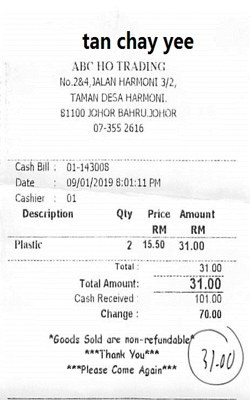

In [7]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))

In [8]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

# Check the length of proc_dataset
print(f"Length of proc_dataset: {len(proc_dataset)}")

# Access a valid index (0 if the length is 1)
valid_index = 0 if len(proc_dataset) == 1 else 1
print(f"Sample: {proc_dataset[valid_index]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Length of proc_dataset: 6
Sample: <s><s_total>60.30</s_total><s_date>19/10/2018</s_date><s_company>INDAH GIFT & HOME DECO</s_company><s_address>27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.</s_address></s>
New special tokens: ['<s_surgical_procedures_and_rvs_codes_if_applicable>', '</s_surgical_procedures_and_rvs_codes_if_applicable>', '<s_summary_of_fees>', '</s_summary_of_fees>', '<s_vat_exempt>', '</s_vat_exempt>', '<s_philhealth_benefits>', '</s_philhealth_benefits>', '<s_second_case_rate_amount>', '</s_second_case_rate_amount>', '<s_first_case_rate_amount>', '</s_first_case_rate_amount>', '<s_particulars>', '</s_particulars>', '<s_out_of_pocket_of_patient>', '</s_out_of_pocket_of_patient>', '<s_amount_of_discounts>', '</s_amount_of_discounts>', '<s_senior_citizen_or_pwd>', '</s_senior_citizen_or_pwd>', '<s_place_others>', '</s_place_others>', '<s_actual_charges>', '</s_actual_charges>', '<s_soa_reference_no>', '</s_soa_reference_no>', '<s_second_case_rate>', '</s

In [9]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:193:

In [10]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [43]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'

In [12]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig, GenerationConfig # import GenerationConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
# Use GenerationConfig for generation parameters
generation_config = GenerationConfig(
    max_length=len(max(processed_dataset["train"]["labels"], key=len))
)
model.generation_config = generation_config
# model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

New embedding size: MBartScaledWordEmbedding(57597, 1024, padding_idx=1)


/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [13]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGr

In [14]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1539: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Start training
trainer.train()

Step,Training Loss


Step,Training Loss


TrainOutput(global_step=9, training_loss=8.633139716254341, metrics={'train_runtime': 1176.2681, 'train_samples_per_second': 0.013, 'train_steps_per_second': 0.008, 'total_flos': 2.6383317055488e+16, 'train_loss': 8.633139716254341, 'epoch': 3.0})

In [17]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashokaswiftclaims/donut-base-sroie/commit/7409ec772726e735a05923bfd917bfe6ad2d3454', commit_message='End of training', commit_description='', oid='7409ec772726e735a05923bfd917bfe6ad2d3454', pr_url=None, pr_revision=None, pr_num=None)

In [40]:
print("Starting the script...")  # Add this at the very beginning

import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from torchvision.transforms.functional import to_pil_image

# hide logs
transformers.logging.disable_default_handler()

# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("ashokaswiftclaims/donut-base-sroie")
model = VisionEncoderDecoderModel.from_pretrained("ashokaswiftclaims/donut-base-sroie")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][0]

def run_prediction(sample, model=model, processor=processor):
    try:
        print("Running prediction...")

        # Prepare inputs
        print("Preparing inputs...")
        pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
        task_prompt = "<s>"
        decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

        print("Running inference...")
        # Run inference
        outputs = model.generate(
            pixel_values.to(device),
            decoder_input_ids=decoder_input_ids.to(device),
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
            decoder_start_token_id=processor.tokenizer.bos_token_id
        )

        # Process output
        print("Processing output...")
        prediction = processor.batch_decode(outputs.sequences)[0]
        prediction = processor.token2json(prediction)

        # Load reference target
        print("Loading reference target...")
        target = processor.token2json(sample["target_sequence"])

        print("Prediction and target successfully processed.")
        return prediction, target

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

# Run the prediction
prediction, target = run_prediction(test_sample)

if prediction and target:
    print(f"Reference:\n {target}")
    print(f"Prediction:\n {prediction}")
else:
    print("Prediction or target is None.")

In [37]:
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

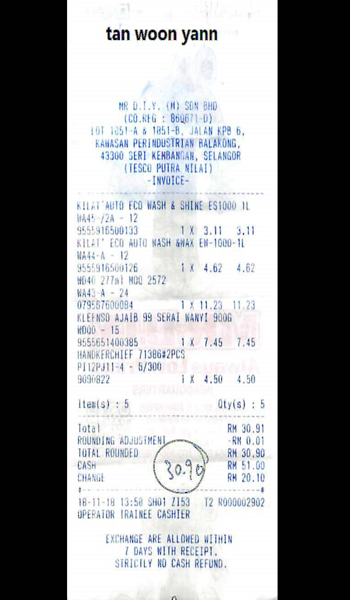

In [26]:
# Investigate the shape and content of pixel_values
print(np.array(test_sample["pixel_values"]).shape)
# Check if the values in pixel_values represent image data as expected

# Extract image data from test_sample and assign it to image_data
image_data = np.array(test_sample["pixel_values"])  # Assuming pixel_values holds the image data
# Transpose the image data to the correct channel order (channels first)
image_data = np.transpose(image_data, (1, 2, 0))

# Now you can use image_data with to_pil_image
to_pil_image(image_data).resize((350,600))

In [29]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")
# Accuracy: 75.0%

100%|██████████| 1/1 [02:11<00:00, 131.54s/it]
